### ResNET is able to outform the CNN model on classification by providing Residual Networks that introduces shortcut connections.
- The problem with deeper network is the issue with degradation, and such degradation is not caused by overfitting as adding more layers to a suitably deep model leads to higher training errors
- The solution provided by ResNET is to have added layers that are identity mapping where other layers are copied from the learned shallower model
- It is also proven that by using deeper ResNET, the error rate decreases.
- It is also showned that adding deeper layer such as the model with 1202 layers, even though it shows that the error increases as compared to the one with 110 layers, it was shown in the graph that the training error is similar when comparing the 110 layers and the 1202 layers, showing that the model could have reach a overfitting situation.

In [21]:
import torch
from torchsummary import summary
from torch import nn

In [22]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential(      # shortcut
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

#### ResBlock contains downsampling where the shortcut is created to contain 1x1 convolution so it skips some of the layers while retaining the identity function

In [23]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample # for shortcut
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, # 1x1
                               kernel_size=1, stride=1) # 1x1
        self.conv2 = nn.Conv2d( # 3x3
            out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1) #  1x1

        if self.downsample or in_channels != out_channels: # shortcut
            self.shortcut = nn.Sequential( # 1x1
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [24]:
class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (
                    i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (
                i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,),resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
             torch.nn.Linear(filters[4], outputs),
             torch.nn.Softmax()
        )
        
    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        # torch.flatten()
        # https://stackoverflow.com/questions/60115633/pytorch-flatten-doesnt-maintain-batch-size
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

In [25]:
resnet18 = ResNet(3, ResBlock, [2, 2, 2, 2], useBottleneck=False, outputs=7)
resnet18.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
       BatchNorm2d-3           [-1, 64, 56, 56]             128
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,928
       BatchNorm2d-8           [-1, 64, 56, 56]             128
          ResBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
         ResBlock-14           [-1, 64,

In [26]:
resnet152 = ResNet(3, ResBottleneckBlock, [
                   3, 8, 36, 3], useBottleneck=True, outputs=7)
resnet152.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(resnet152, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
       BatchNorm2d-3           [-1, 64, 56, 56]             128
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,640
       BatchNorm2d-6          [-1, 256, 56, 56]             512
            Conv2d-7           [-1, 64, 56, 56]           4,160
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9           [-1, 64, 56, 56]          36,928
      BatchNorm2d-10           [-1, 64, 56, 56]             128
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
ResBottleneckBlock-13          [-1, 256, 56, 56]               0
           Conv2d-14           [-1, 64

### Training and testing the data using ResNet18

In [27]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [28]:
# load data from data folder
training_data = datasets.ImageFolder(root='train', transform=ToTensor())
test_data = datasets.ImageFolder(root='test', transform=ToTensor())



In [29]:
# create data loaders
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle= True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break



Shape of X [N, C, H, W]: torch.Size([128, 3, 48, 48])
Shape of y: torch.Size([128]) torch.int64


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Define the training function
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(total=28709//128 + 1)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.update(1)
    pbar.close()
    print('loss: %.3f' % (running_loss / len(train_loader)))
    return running_loss / len(train_loader)

# Define the testing function
def test(test_loader, model, loss_fn, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += loss_fn(outputs, labels).item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()   
             
    test_loss /= len(test_loader.dataset)
    print(f"Test Error: \n Accuracy: {(100 * correct / total):.2f}%, Avg loss: {test_loss:.2f} \n")
    return (correct / total)*100

In [31]:
model = resnet18
# Define the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Optimizing the model parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [32]:
test_accuracies = []
# Training and testing the model
epochs = 64
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    acc = test(test_dataloader, model, loss_fn, device)
    test_accuracies.append(acc)    

Epoch 1
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.807
Test Error: 
 Accuracy: 38.62%, Avg loss: 0.01 

Epoch 2
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.724
Test Error: 
 Accuracy: 38.90%, Avg loss: 0.01 

Epoch 3
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.686
Test Error: 
 Accuracy: 46.34%, Avg loss: 0.01 

Epoch 4
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.652
Test Error: 
 Accuracy: 46.27%, Avg loss: 0.01 

Epoch 5
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.623
Test Error: 
 Accuracy: 46.88%, Avg loss: 0.01 

Epoch 6
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.599
Test Error: 
 Accuracy: 50.84%, Avg loss: 0.01 

Epoch 7
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.577
Test Error: 
 Accuracy: 46.70%, Avg loss: 0.01 

Epoch 8
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.562
Test Error: 
 Accuracy: 53.00%, Avg loss: 0.01 

Epoch 9
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.539
Test Error: 
 Accuracy: 49.69%, Avg loss: 0.01 

Epoch 10
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.524
Test Error: 
 Accuracy: 52.79%, Avg loss: 0.01 

Epoch 11
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.507
Test Error: 
 Accuracy: 48.84%, Avg loss: 0.01 

Epoch 12
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.493
Test Error: 
 Accuracy: 51.21%, Avg loss: 0.01 

Epoch 13
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.479
Test Error: 
 Accuracy: 49.41%, Avg loss: 0.01 

Epoch 14
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.463
Test Error: 
 Accuracy: 51.56%, Avg loss: 0.01 

Epoch 15
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.452
Test Error: 
 Accuracy: 50.17%, Avg loss: 0.01 

Epoch 16
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.437
Test Error: 
 Accuracy: 53.46%, Avg loss: 0.01 

Epoch 17
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.427
Test Error: 
 Accuracy: 52.72%, Avg loss: 0.01 

Epoch 18
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.414
Test Error: 
 Accuracy: 53.52%, Avg loss: 0.01 

Epoch 19
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.407
Test Error: 
 Accuracy: 53.93%, Avg loss: 0.01 

Epoch 20
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.400
Test Error: 
 Accuracy: 54.56%, Avg loss: 0.01 

Epoch 21
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.388
Test Error: 
 Accuracy: 55.22%, Avg loss: 0.01 

Epoch 22
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.378
Test Error: 
 Accuracy: 55.35%, Avg loss: 0.01 

Epoch 23
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.372
Test Error: 
 Accuracy: 55.61%, Avg loss: 0.01 

Epoch 24
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.367
Test Error: 
 Accuracy: 51.35%, Avg loss: 0.01 

Epoch 25
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.359
Test Error: 
 Accuracy: 52.05%, Avg loss: 0.01 

Epoch 26
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.357
Test Error: 
 Accuracy: 53.20%, Avg loss: 0.01 

Epoch 27
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.349
Test Error: 
 Accuracy: 55.60%, Avg loss: 0.01 

Epoch 28
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.347
Test Error: 
 Accuracy: 54.63%, Avg loss: 0.01 

Epoch 29
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.340
Test Error: 
 Accuracy: 54.50%, Avg loss: 0.01 

Epoch 30
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.337
Test Error: 
 Accuracy: 53.12%, Avg loss: 0.01 

Epoch 31
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.334
Test Error: 
 Accuracy: 49.11%, Avg loss: 0.01 

Epoch 32
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.330
Test Error: 
 Accuracy: 54.67%, Avg loss: 0.01 

Epoch 33
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.330
Test Error: 
 Accuracy: 55.53%, Avg loss: 0.01 

Epoch 34
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.327
Test Error: 
 Accuracy: 55.02%, Avg loss: 0.01 

Epoch 35
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.323
Test Error: 
 Accuracy: 54.86%, Avg loss: 0.01 

Epoch 36
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.317
Test Error: 
 Accuracy: 49.23%, Avg loss: 0.01 

Epoch 37
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.316
Test Error: 
 Accuracy: 48.13%, Avg loss: 0.01 

Epoch 38
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.316
Test Error: 
 Accuracy: 55.88%, Avg loss: 0.01 

Epoch 39
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.316
Test Error: 
 Accuracy: 54.49%, Avg loss: 0.01 

Epoch 40
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.310
Test Error: 
 Accuracy: 53.26%, Avg loss: 0.01 

Epoch 41
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.305
Test Error: 
 Accuracy: 54.56%, Avg loss: 0.01 

Epoch 42
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.306
Test Error: 
 Accuracy: 54.49%, Avg loss: 0.01 

Epoch 43
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.303
Test Error: 
 Accuracy: 54.32%, Avg loss: 0.01 

Epoch 44
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.302
Test Error: 
 Accuracy: 53.97%, Avg loss: 0.01 

Epoch 45
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.299
Test Error: 
 Accuracy: 56.06%, Avg loss: 0.01 

Epoch 46
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.297
Test Error: 
 Accuracy: 55.56%, Avg loss: 0.01 

Epoch 47
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.299
Test Error: 
 Accuracy: 53.19%, Avg loss: 0.01 

Epoch 48
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.296
Test Error: 
 Accuracy: 56.06%, Avg loss: 0.01 

Epoch 49
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.298
Test Error: 
 Accuracy: 52.79%, Avg loss: 0.01 

Epoch 50
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.293
Test Error: 
 Accuracy: 54.95%, Avg loss: 0.01 

Epoch 51
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.290
Test Error: 
 Accuracy: 52.41%, Avg loss: 0.01 

Epoch 52
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.290
Test Error: 
 Accuracy: 54.43%, Avg loss: 0.01 

Epoch 53
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.289
Test Error: 
 Accuracy: 54.03%, Avg loss: 0.01 

Epoch 54
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.286
Test Error: 
 Accuracy: 54.85%, Avg loss: 0.01 

Epoch 55
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.287
Test Error: 
 Accuracy: 55.88%, Avg loss: 0.01 

Epoch 56
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.283
Test Error: 
 Accuracy: 55.42%, Avg loss: 0.01 

Epoch 57
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.282
Test Error: 
 Accuracy: 56.39%, Avg loss: 0.01 

Epoch 58
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.280
Test Error: 
 Accuracy: 55.28%, Avg loss: 0.01 

Epoch 59
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.283
Test Error: 
 Accuracy: 54.25%, Avg loss: 0.01 

Epoch 60
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.276
Test Error: 
 Accuracy: 56.12%, Avg loss: 0.01 

Epoch 61
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.277
Test Error: 
 Accuracy: 55.56%, Avg loss: 0.01 

Epoch 62
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.276
Test Error: 
 Accuracy: 56.19%, Avg loss: 0.01 

Epoch 63
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.275
Test Error: 
 Accuracy: 55.88%, Avg loss: 0.01 

Epoch 64
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.275
Test Error: 
 Accuracy: 56.39%, Avg loss: 0.01 



In [33]:
torch.save(model.state_dict(), "model resnet18.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [49]:
model = resnet18
model.load_state_dict(torch.load("model resnet18.pth"))
model.to(device)

ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (conv2_1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2_2): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=

In [48]:
print('resnet18')
test(test_dataloader, model, loss_fn)

resnet18


TypeError: test() missing 1 required positional argument: 'device'

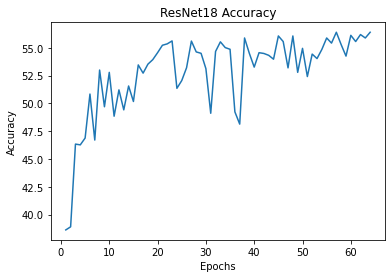

In [42]:
import matplotlib.pyplot as plt

x_axis = [i for i in range(1, epochs+1)]
plt.plot(x_axis, test_accuracies)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet18 Accuracy')

plt.show()

In [52]:
model2 = resnet152
# Define the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Optimizing the model parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [53]:
test_accuracies = []
# Training and testing the model
epochs = 64
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model2, loss_fn, optimizer, device)
    acc = test(test_dataloader, model2, loss_fn, device)
    test_accuracies.append(acc)    

Epoch 1
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

loss: 1.957
Test Error: 
 Accuracy: 5.25%, Avg loss: 0.02 

Epoch 2
-------------------------------


  0%|          | 0/225 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "model resnet152.pth")
print("Saved PyTorch Model State to model.pth")


In [ ]:
model2 = resnet152
model2.load_state_dict(torch.load("model resnet152.pth"))
model2.to(device)

In [ ]:
print('resnet152')
test(test_dataloader, model2, loss_fn)

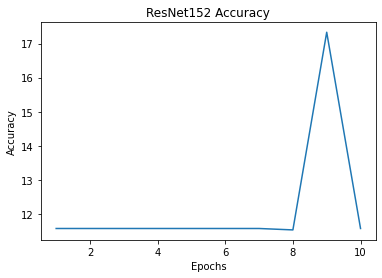

In [ ]:
import matplotlib.pyplot as plt

x_axis = [i for i in range(1, epochs+1)]
plt.plot(x_axis, test_accuracies)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet152 Accuracy')

plt.show()

#### As compared to the classical CNN, ResNet is doing much better with similar loss_fn and optimizer